# Analisis Clustering: Implementasi dari Awal

Notebook ini berisi implementasi dari awal (from scratch) untuk alur kerja clustering menggunakan library dasar seperti NumPy dan Pandas.

### 1. Import Libraries dan Persiapan Data

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 1.1 Memuat dan Membersihkan Data ---
df = pd.read_csv('dataset_100_resp.csv')
columns_to_drop = ['Timestamp', 'Jenis Kelamin', 'Angkatan (Tahun Masuk)', 'Semester saat ini', 'IPK terakhir ', 'Status aktivitas akademik', 'Platform media sosial yang sering dipakai', 'Email address']
df_cleaned = df.drop(columns=columns_to_drop)

# --- 1.2 Encoding (One-Hot) ---
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Memastikan semua data numerik
df_numeric = df_encoded.astype(np.float64)

# --- 1.3 Konversi ke NumPy Array ---
data_initial = df_numeric.to_numpy()

print(f"Data siap dengan dimensi: {data_initial.shape}")

Data siap dengan dimensi: (100, 30)


### 2. Fungsi Preprocessing dari Awal

In [16]:
def standard_scaler_from_scratch(X):
    """Standarisasi data (mean=0, std=1) per kolom."""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    # Tambahkan nilai kecil (epsilon) untuk menghindari pembagian dengan nol
    epsilon = 1e-8
    return (X - mean) / (std + epsilon)

def pca_from_scratch(X, n_components):
    """Principal Component Analysis dari awal."""
    # Standarisasi data terlebih dahulu
    X_scaled = standard_scaler_from_scratch(X)
    
    # Hitung matriks kovarians
    cov_matrix = np.cov(X_scaled.T)
    
    # Hitung eigenvectors dan eigenvalues
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Urutkan eigenvectors berdasarkan eigenvalues
    eigen_pairs = [0] * len(eigenvalues) 
    for i in range(len(eigenvalues)):
        eigen_pairs[i] = (np.abs(eigenvalues[i]), eigenvectors[:, i])
    eigen_pairs.sort(key=lambda x: x[0], reverse=True)
    
    # Pilih komponen utama
    # Siapkan array NumPy kosong dengan ukuran yang tepat
    n_features = eigenvectors.shape[0]
    projection_matrix_temp = np.zeros((n_components, n_features))

    # Loop untuk mengisi setiap baris pada array
    for i in range(n_components):
        vector = np.array(eigen_pairs[i][1])
        projection_matrix_temp[i] = vector
    projection_matrix = projection_matrix_temp.T 

    projection_matrix = np.array([eigen_pairs[i][1] for i in range(n_components)]).T
    
    # Proyeksikan data
    return X_scaled.dot(projection_matrix)

### 3. Fungsi Algoritma Clustering dari Awal

In [17]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

def kmeans_from_scratch(X, k, max_iters=100, random_state=42):
    np.random.seed(random_state)
    rand_indices = np.random.choice(X.shape[0], size=k, replace=False)
    centroids = X[rand_indices, :]
    
    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]
        for idx, point in enumerate(X):
            closest_centroid_idx = np.argmin([euclidean_distance(point, c) for c in centroids])
            clusters[closest_centroid_idx].append(idx)
        
        old_centroids = centroids.copy()
        for i, cluster in enumerate(clusters):
            if cluster: centroids[i] = np.mean(X[cluster], axis=0)
        
        if np.all([euclidean_distance(old_centroids[i], centroids[i]) for i in range(k)]) == 0:
            break
            
    labels = np.empty(X.shape[0], dtype=int)
    for i, cluster in enumerate(clusters):
        for point_idx in cluster:
            labels[point_idx] = i
    return labels

def dbscan_from_scratch(X, eps, min_samples):
    n_points = X.shape[0]
    labels = -1 * np.ones(n_points) # -1 untuk noise
    cluster_id = 0

    for i in range(n_points):
        if labels[i] != -1: continue # Sudah diproses
        
        neighbors = [j for j in range(n_points) if euclidean_distance(X[i], X[j]) < eps]
        
        if len(neighbors) < min_samples:
            continue # Tetap sebagai noise untuk sementara
        
        # Titik ini adalah core point, mulai cluster baru
        labels[i] = cluster_id
        seed_set = set(neighbors)
        seed_set.remove(i)
        
        while seed_set:
            current_point = seed_set.pop()
            if labels[current_point] == -1:
                labels[current_point] = cluster_id
            
            current_neighbors = [j for j in range(n_points) if euclidean_distance(X[current_point], X[j]) < eps]
            
            if len(current_neighbors) >= min_samples:
                new_neighbors = set(current_neighbors)
                # Tambahkan titik yang belum diproses ke seed_set
                seed_set.update([p for p in new_neighbors if labels[p] == -1])
        
        cluster_id += 1
    return labels

def ahc_from_scratch(X, n_clusters):
    # Menggunakan metode single-linkage (jarak minimum antar cluster)
    n_samples = X.shape[0]
    clusters = [[i] for i in range(n_samples)]
    
    while len(clusters) > n_clusters:
        min_dist = float('inf')
        merge_idx = (-1, -1)
        
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                # Cari jarak minimum antar titik di dua cluster
                dist = min([euclidean_distance(X[p1], X[p2]) for p1 in clusters[i] for p2 in clusters[j]])
                if dist < min_dist:
                    min_dist = dist
                    merge_idx = (i, j)
        
        # Gabungkan dua cluster terdekat
        i, j = merge_idx
        clusters[i].extend(clusters[j])
        clusters.pop(j)
        
    labels = np.empty(n_samples, dtype=int)
    for i, cluster in enumerate(clusters):
        for point_idx in cluster:
            labels[point_idx] = i
    return labels

### 4. Fungsi Evaluasi dari Awal

In [18]:
def silhouette_score_from_scratch(X, labels):
    n_samples = len(X)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    
    if n_clusters < 2:
        return float('nan') # Skor tidak bisa dihitung
    
    silhouette_vals = []
    for i in range(n_samples):
        # a(i): Rata-rata jarak ke titik lain di cluster yang sama
        own_cluster_label = labels[i]
        own_cluster_indices = np.where(labels == own_cluster_label)[0]
        if len(own_cluster_indices) <= 1:
            a_i = 0
        else:
            a_i = np.mean([euclidean_distance(X[i], X[j]) for j in own_cluster_indices if i != j])
        
        # b(i): Rata-rata jarak minimum ke cluster lain
        b_i = float('inf')
        for label in unique_labels:
            if label == own_cluster_label: continue
            other_cluster_indices = np.where(labels == label)[0]
            mean_dist = np.mean([euclidean_distance(X[i], X[j]) for j in other_cluster_indices])
            if mean_dist < b_i:
                b_i = mean_dist
        
        if max(a_i, b_i) == 0:
             s_i = 0
        else:
            s_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_vals.append(s_i)
    
    return np.mean(silhouette_vals)

### 5. Menjalankan Alur Kerja & Evaluasi

In [19]:
# 5.1 Preprocessing: Scaling dan PCA
print("Melakukan Preprocessing...")
data_pca = pca_from_scratch(data_initial, n_components=2)
print("Preprocessing Selesai.")

# 5.2 Menjalankan Algoritma Clustering
print("\nMenjalankan Clustering...")
k = 4
kmeans_labels_fs = kmeans_from_scratch(data_pca, k=k, random_state=42)
ahc_labels_fs = ahc_from_scratch(data_pca, n_clusters=k)
dbscan_labels_fs = dbscan_from_scratch(data_pca, eps=0.7, min_samples=4)
print("Clustering Selesai.")

# 5.3 Evaluasi Skor
print("\nMenghitung Skor...")
kmeans_score_fs = silhouette_score_from_scratch(data_pca, kmeans_labels_fs)
ahc_score_fs = silhouette_score_from_scratch(data_pca, ahc_labels_fs)

# Untuk DBSCAN, abaikan noise points (label -1) saat menghitung skor

# list kosong untuk menampung data non-noise
core_data_dbscan = []
core_labels_dbscan = []

for i in range(len(dbscan_labels_fs)):
    # Jika labelnya BUKAN -1 (bukan noise)
    if dbscan_labels_fs[i] != -1:
        # Masukkan data dan labelnya ke list baru
        core_data_dbscan.append(data_pca[i])
        core_labels_dbscan.append(dbscan_labels_fs[i])

# 3. Ubah kembali ke NumPy array agar bisa dihitung
core_data_dbscan = np.array(core_data_dbscan)

# 4. Hitung skor hanya pada data yang sudah difilter (non-noise)
if len(core_data_dbscan) > 1 and len(set(core_labels_dbscan)) > 1:
    dbscan_score_fs = silhouette_score_from_scratch(core_data_dbscan, core_labels_dbscan)
else:
    dbscan_score_fs = float('nan') # Tidak dihitung jika tidak ada cluster

print(f"Silhouette Score (from scratch) untuk K-Means: {kmeans_score_fs:.3f}")
print(f"Silhouette Score (from scratch) untuk AHC: {ahc_score_fs:.3f}")
print(f"Silhouette Score (from scratch) untuk DBSCAN: {dbscan_score_fs:.3f}")

Melakukan Preprocessing...
Preprocessing Selesai.

Menjalankan Clustering...
Clustering Selesai.

Menghitung Skor...
Silhouette Score (from scratch) untuk K-Means: 0.337
Silhouette Score (from scratch) untuk AHC: 0.294
Silhouette Score (from scratch) untuk DBSCAN: 0.260


### 6. Visualisasi Hasil

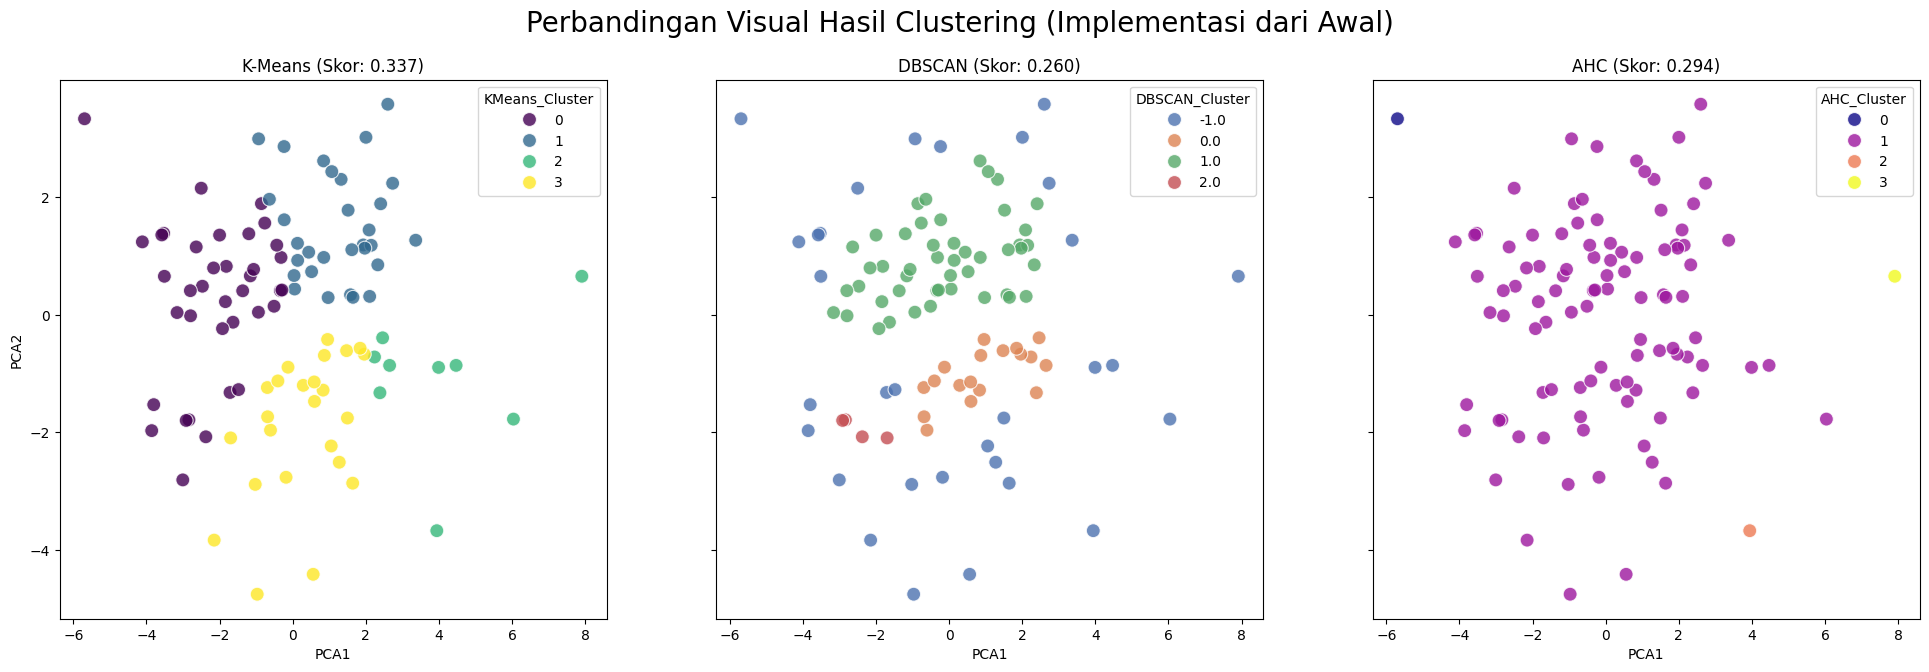

In [20]:
df_plot = pd.DataFrame(data_pca, columns=['PCA1', 'PCA2'])
df_plot['KMeans_Cluster'] = kmeans_labels_fs
df_plot['DBSCAN_Cluster'] = dbscan_labels_fs
df_plot['AHC_Cluster'] = ahc_labels_fs

# Visualisasi Hasil Clustering

fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharex=True, sharey=True)

sns.scatterplot(ax=axes[0], data=df_plot, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', s=100, alpha=0.8)
axes[0].set_title(f'K-Means (Skor: {kmeans_score_fs:.3f})')

sns.scatterplot(ax=axes[1], data=df_plot, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='deep', s=100, alpha=0.8)
axes[1].set_title(f'DBSCAN (Skor: {dbscan_score_fs:.3f})')

sns.scatterplot(ax=axes[2], data=df_plot, x='PCA1', y='PCA2', hue='AHC_Cluster', palette='plasma', s=100, alpha=0.8)
axes[2].set_title(f'AHC (Skor: {ahc_score_fs:.3f})')

plt.suptitle('Perbandingan Visual Hasil Clustering (Implementasi dari Awal)', fontsize=20)
plt.show()

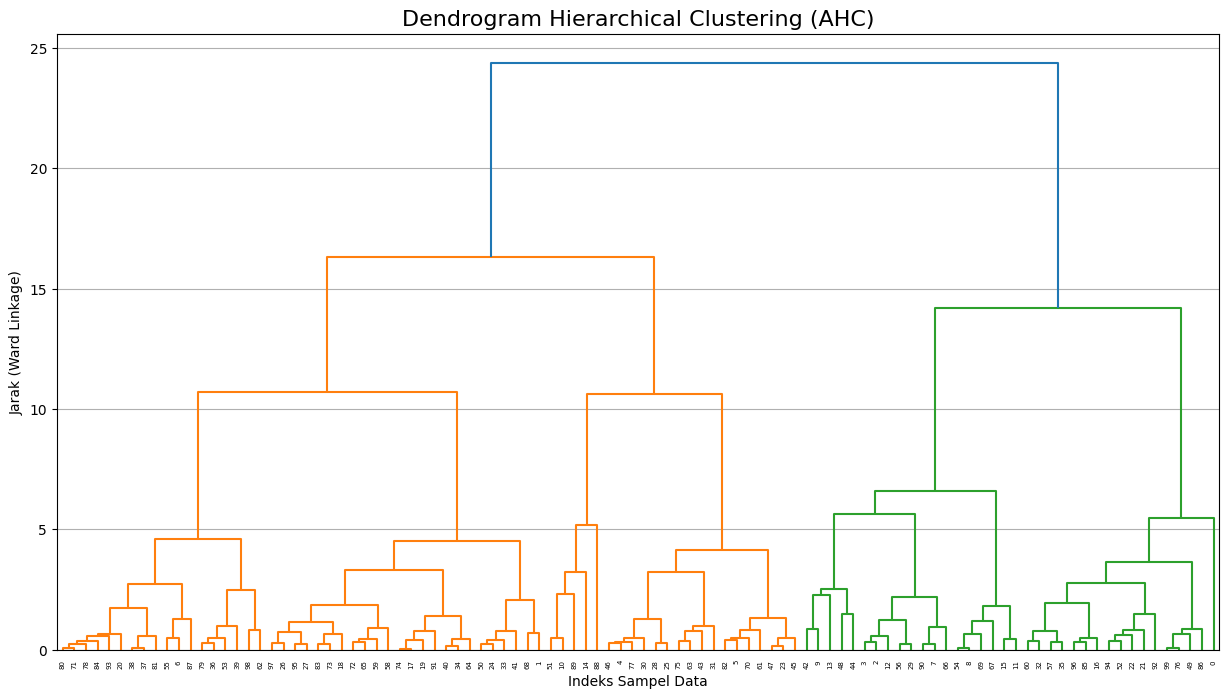

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Menghitung linkage matrix menggunakan metode 'ward' dari data PCA
# Metode 'ward' bertujuan meminimalkan varians saat cluster digabungkan
linked = linkage(data_pca, method='ward')

# Membuat plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)

plt.title('Dendrogram Hierarchical Clustering (AHC)', fontsize=16)
plt.xlabel('Indeks Sampel Data')
plt.ylabel('Jarak (Ward Linkage)')
plt.grid(axis='y') # Menambahkan grid pada sumbu y untuk mempermudah pembacaan jarak
plt.show()